<a href="https://colab.research.google.com/github/Shekhawat34/Machine-Learning-Project/blob/main/Breast_Cancer_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Breast Cancer Prediction

In [2]:

!pip install kaggle

from google.colab import files
files.upload()

!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


Saving kaggle.json to kaggle.json


In [3]:
!kaggle datasets download -d hayder17/breast-cancer-detection

import zipfile
zip_ref = zipfile.ZipFile('breast-cancer-detection.zip', 'r')
zip_ref.extractall('/content/Breast_Cancer_Detection')
zip_ref.close()


Dataset URL: https://www.kaggle.com/datasets/hayder17/breast-cancer-detection
License(s): DbCL-1.0
 91% 79.0M/87.2M [00:00<00:00, 132MB/s]
100% 87.2M/87.2M [00:00<00:00, 116MB/s]


In [4]:
import os

for root, dirs, files in os.walk('/content/Breast_Cancer_Detection'):
  for dir_name in dirs:
    print(os.path.join(root, dir_name))


/content/Breast_Cancer_Detection/test
/content/Breast_Cancer_Detection/valid
/content/Breast_Cancer_Detection/train
/content/Breast_Cancer_Detection/test/0
/content/Breast_Cancer_Detection/test/1
/content/Breast_Cancer_Detection/valid/0
/content/Breast_Cancer_Detection/valid/1
/content/Breast_Cancer_Detection/train/0
/content/Breast_Cancer_Detection/train/1


In [5]:
import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision import datasets, transforms


## Image Transformation

In [6]:
data_transforms={
    'train':transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])

    ]),
    'valid':transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])

    ]),

    'test':transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])

    ])
}

## Load Data

In [7]:
data_dir='/content/Breast_Cancer_Detection'

#Load Datasets
image_datasets={
    'train':datasets.ImageFolder(root=f'{data_dir}/train',transform=data_transforms['train']),
    'valid':datasets.ImageFolder(root=f'{data_dir}/valid',transform=data_transforms['valid']),
    'test':datasets.ImageFolder(root=f'{data_dir}/test',transform=data_transforms['test'])
}


In [8]:
dataloaders={
    'train':DataLoader(image_datasets['train'],batch_size=32,shuffle=True,num_workers=4),
    'valid':DataLoader(image_datasets['valid'],batch_size=32,shuffle=True,num_workers=4),
    'test':DataLoader(image_datasets['test'],batch_size=32,shuffle=True,num_workers=4)

}


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


## Dataset Size

In [9]:
dataset_size={x:len(image_datasets[x]) for x in ['train','valid','test']}
print(dataset_size)

{'train': 2372, 'valid': 675, 'test': 336}


## Get Class Names

In [10]:
class_names=image_datasets['train'].classes
print(f"Classes: {class_names}")

Classes: ['0', '1']


## Dataset and Sample Batches

In [11]:
import matplotlib.pyplot as plt
import numpy as np

#Helper function to visualize a batch of images
def imshow(inp,title=None):
  inp=inp.numpy().transpose((1,2,0))
  mean=np.array([0.485,0.456,0.406])
  std=np.array([0.229,0.224,0.225])
  inp=std*inp+mean
  inp=np.clip(inp,0,1)
  plt.imshow(inp)
  if title is not None:
    plt.title(title)
  plt.show()


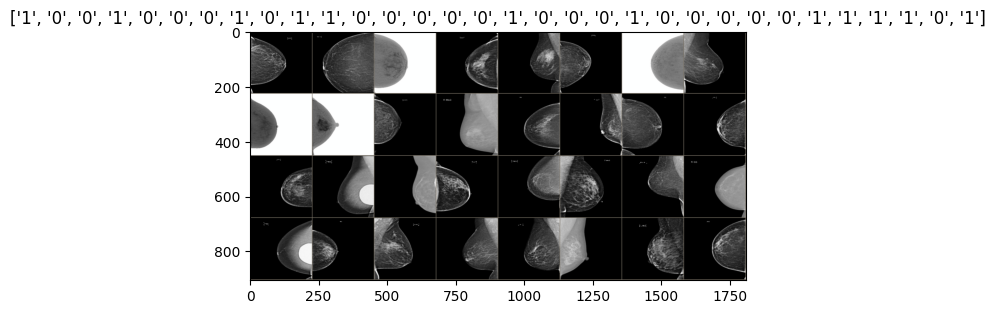

In [12]:
inputs,classes=next(iter(dataloaders['train']))
out=torchvision.utils.make_grid(inputs)
imshow(out,title=[class_names[x] for x in classes])

In [13]:
print(f"Training set size: {dataset_size['train']}")
print(f"Validation set size: {dataset_size['valid']}")
print(f"Test set size: {dataset_size['test']}")

Training set size: 2372
Validation set size: 675
Test set size: 336


## Model_0 : CNN

In [35]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN_Model(nn.Module):
    def __init__(self):
        super(CNN_Model, self).__init__()


        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)


        self.fc1 = nn.Linear(128 * 28 * 28, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 2)


        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):

        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))

        # Flatten the tensor before passing through fully connected layers
        x = x.view(-1, 128 * 28 * 28)


        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)  # No activation here, as we'll apply softmax/cross entropy in the loss function

        return x


## Loss Function and Optimizer

In [36]:
import torch.optim as optim
import torch.nn as nn

model_0=CNN_Model()

loss_fn=nn.CrossEntropyLoss()
optimizer=optim.Adam(model_0.parameters(),lr=0.001)

In [37]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_0 = model_0.to(device)

# Move loss function to GPU if needed
criterion = loss_fn.to(device)


In [17]:
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


## Train Model Function

In [38]:
import time
import copy

def train_model(model, dataloaders, dataset_sizes, criterion, optimizer, num_epochs=25):
    since = time.time()


    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0


    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)


        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0


            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)


                optimizer.zero_grad()


                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)


                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')


            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best validation accuracy: {best_acc:.4f}')


    model.load_state_dict(best_model_wts)
    return model


In [39]:

num_epochs = 25


model_0 = train_model(model_0, dataloaders, dataset_size, criterion, optimizer, num_epochs)


Epoch 0/24
----------
train Loss: 0.7283 Acc: 0.6442
valid Loss: 0.6810 Acc: 0.6637

Epoch 1/24
----------
train Loss: 0.6587 Acc: 0.6615
valid Loss: 0.6391 Acc: 0.6637

Epoch 2/24
----------
train Loss: 0.6386 Acc: 0.6615
valid Loss: 0.6398 Acc: 0.6637

Epoch 3/24
----------
train Loss: 0.6424 Acc: 0.6619
valid Loss: 0.6334 Acc: 0.6637

Epoch 4/24
----------
train Loss: 0.6313 Acc: 0.6615
valid Loss: 0.6731 Acc: 0.6637

Epoch 5/24
----------
train Loss: 0.6376 Acc: 0.6615
valid Loss: 0.6366 Acc: 0.6637

Epoch 6/24
----------
train Loss: 0.6304 Acc: 0.6619
valid Loss: 0.6274 Acc: 0.6637

Epoch 7/24
----------
train Loss: 0.6230 Acc: 0.6610
valid Loss: 0.6298 Acc: 0.6637

Epoch 8/24
----------
train Loss: 0.6183 Acc: 0.6551
valid Loss: 0.7203 Acc: 0.6637

Epoch 9/24
----------
train Loss: 0.6574 Acc: 0.6610
valid Loss: 0.6513 Acc: 0.6637

Epoch 10/24
----------
train Loss: 0.6245 Acc: 0.6606
valid Loss: 0.6267 Acc: 0.6607

Epoch 11/24
----------
train Loss: 0.6164 Acc: 0.6632
valid Loss

## Evaluate the model_0

In [40]:
def evaluate_model(model,dataloader):
  model.eval()
  running_corrects=0
  total=0

  with torch.no_grad():
    for inputs,labels in dataloader:
      inputs=inputs.to(device)
      labels=labels.to(device)

      outputs=model(inputs)
      _,preds=torch.max(outputs,1)
      running_corrects+=torch.sum(preds==labels.data)
      total+=labels.size(0)

  accuracy=running_corrects.double()/total
  print(f"Accuracy: {accuracy:.4f}")

evaluate_model(model_0,dataloaders['test'])

Accuracy: 0.5833


## Data Augmentation

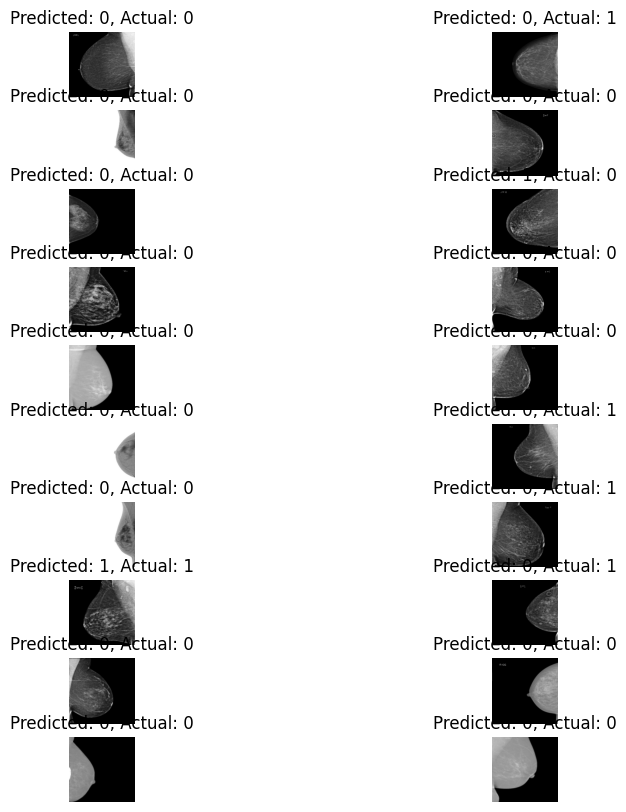

In [41]:
def visualize_predictions(model, dataloader, num_images=6):
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(10, 10))

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'Predicted: {preds[j]}, Actual: {labels[j]}')


                img = inputs.cpu().data[j]
                img = img * torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1) + torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
                img = img.numpy().transpose((1, 2, 0))
                plt.imshow(img)

                if images_so_far == num_images:
                    return


visualize_predictions(model_0, dataloaders['test'], num_images=20)


## Improved CNN model

In [42]:


class ImprovedCNN_Model(nn.Module):
    def __init__(self):
        super(ImprovedCNN_Model, self).__init__()

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1)

        self.fc1 = nn.Linear(512 * 14 * 14, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 2)

        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))

        x = x.view(-1, 512 * 14 * 14)

        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)

        return x


model_improved = ImprovedCNN_Model()
model_improved = model_improved.to(device)
optimizer_improved = optim.AdamW(model_improved.parameters(), lr=0.0001)
criterion_improved = nn.CrossEntropyLoss().to(device)




In [43]:
num_epochs_improved = 50

model_improved = train_model(model_improved, dataloaders, dataset_size, criterion_improved, optimizer_improved, num_epochs_improved)


Epoch 0/49
----------
train Loss: 0.6436 Acc: 0.6615
valid Loss: 0.6445 Acc: 0.6637

Epoch 1/49
----------
train Loss: 0.6431 Acc: 0.6615
valid Loss: 0.6369 Acc: 0.6637

Epoch 2/49
----------
train Loss: 0.6354 Acc: 0.6615
valid Loss: 0.6274 Acc: 0.6637

Epoch 3/49
----------
train Loss: 0.6354 Acc: 0.6615
valid Loss: 0.6205 Acc: 0.6637

Epoch 4/49
----------
train Loss: 0.6264 Acc: 0.6589
valid Loss: 0.6166 Acc: 0.6637

Epoch 5/49
----------
train Loss: 0.6183 Acc: 0.6644
valid Loss: 0.6119 Acc: 0.6770

Epoch 6/49
----------
train Loss: 0.6090 Acc: 0.6703
valid Loss: 0.6155 Acc: 0.6830

Epoch 7/49
----------
train Loss: 0.5946 Acc: 0.6847
valid Loss: 0.6206 Acc: 0.6622

Epoch 8/49
----------
train Loss: 0.5918 Acc: 0.6906
valid Loss: 0.6135 Acc: 0.6681

Epoch 9/49
----------
train Loss: 0.5842 Acc: 0.6868
valid Loss: 0.6179 Acc: 0.6652

Epoch 10/49
----------
train Loss: 0.5669 Acc: 0.7040
valid Loss: 0.6082 Acc: 0.6667

Epoch 11/49
----------
train Loss: 0.5662 Acc: 0.7040
valid Loss

In [44]:
evaluate_model(model_improved, dataloaders['test'])


Accuracy: 0.6339


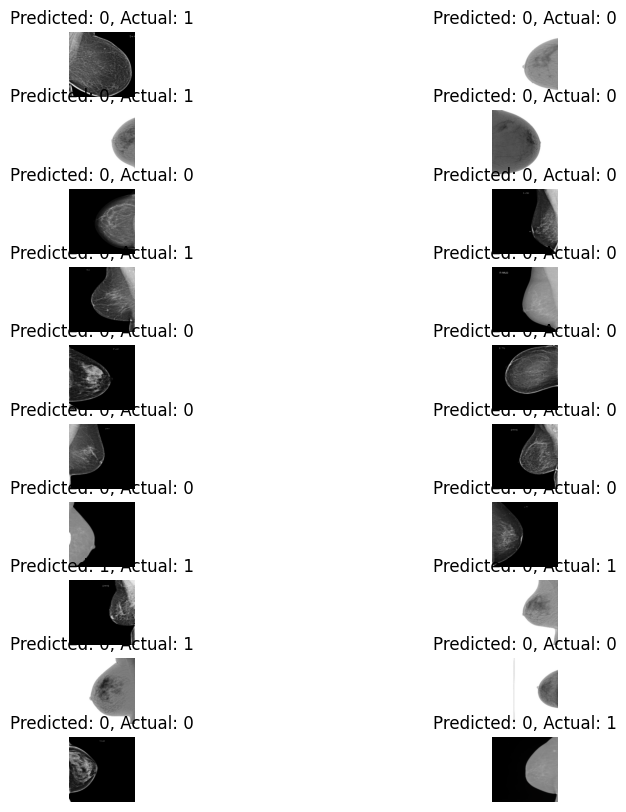

In [45]:
visualize_predictions(model_improved, dataloaders['test'], num_images=20)

## Save the model

In [46]:

torch.save(model_improved.state_dict(), 'breast_cancer_best_model.pth')
